# Install Dependencies

In [ ]:
!pip install pymupdf
!pip install pdf2image
!apt-get install poppler-utils

In [14]:
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q timm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00


# PDF pre-process

### Save single page of PDF (page69)

In [6]:
import fitz

doc = fitz.open("assets/keppel-corporation-limited-annual-report-2018.pdf")
doc.select([68]) # Select page 69
doc.save("assets/page69.pdf")

### Convert PDF to Image

In [12]:
from pdf2image import convert_from_path

images = convert_from_path("assets/page69.pdf")
images[0].save("assets/page69_img.jpg","JPEG")

# Table Detection

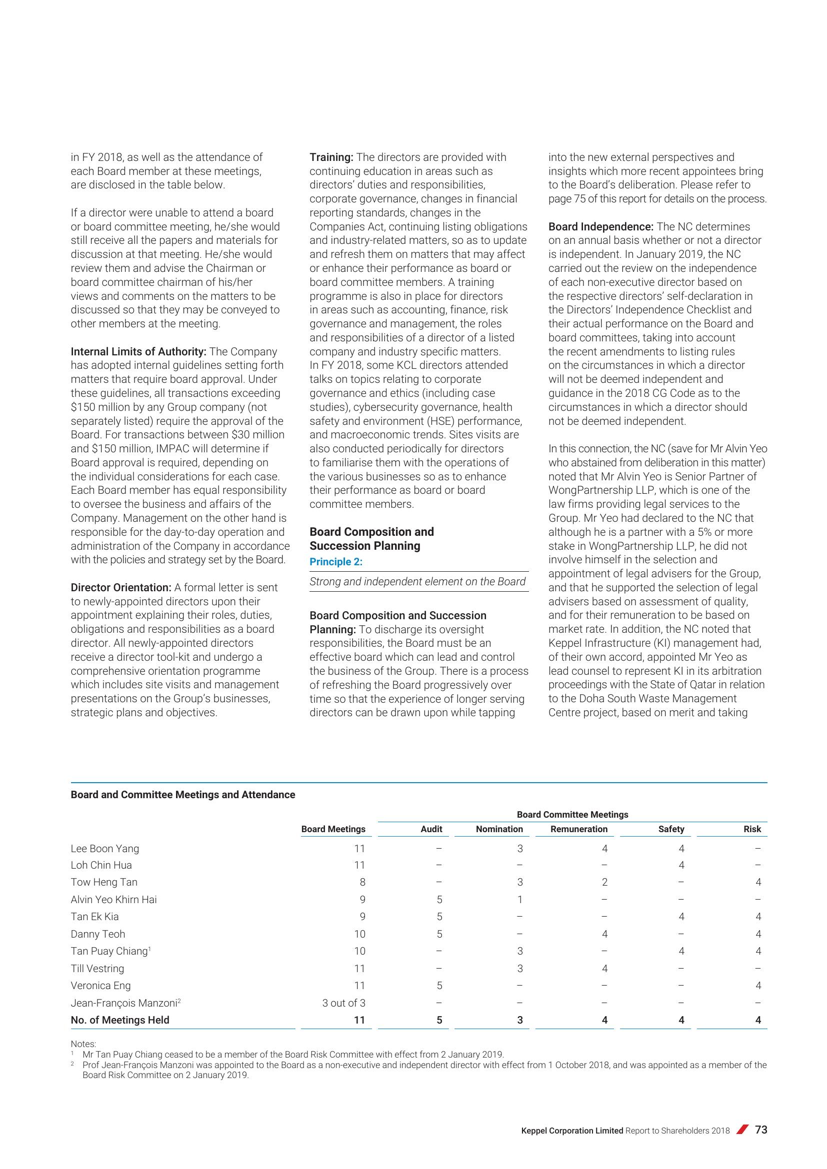

In [16]:
# Reads image
from PIL import Image

file_path = "assets/page69_img.jpg"
image = Image.open(file_path).convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

In [17]:
# Feature extraction
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


dict_keys(['pixel_values', 'pixel_mask'])

In [18]:
print(encoding['pixel_values'].shape)

torch.Size([1, 3, 1131, 800])


In [19]:
# Download pre-trained model
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [20]:
import torch

with torch.no_grad():
  outputs = model(**encoding)

In [30]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(24,16))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=1))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=8,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.savefig('assets/bbox_table.jpg', pad_inches=0, bbox_inches="tight")
    plt.show()

In [22]:
# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=[(height, width)])[0]

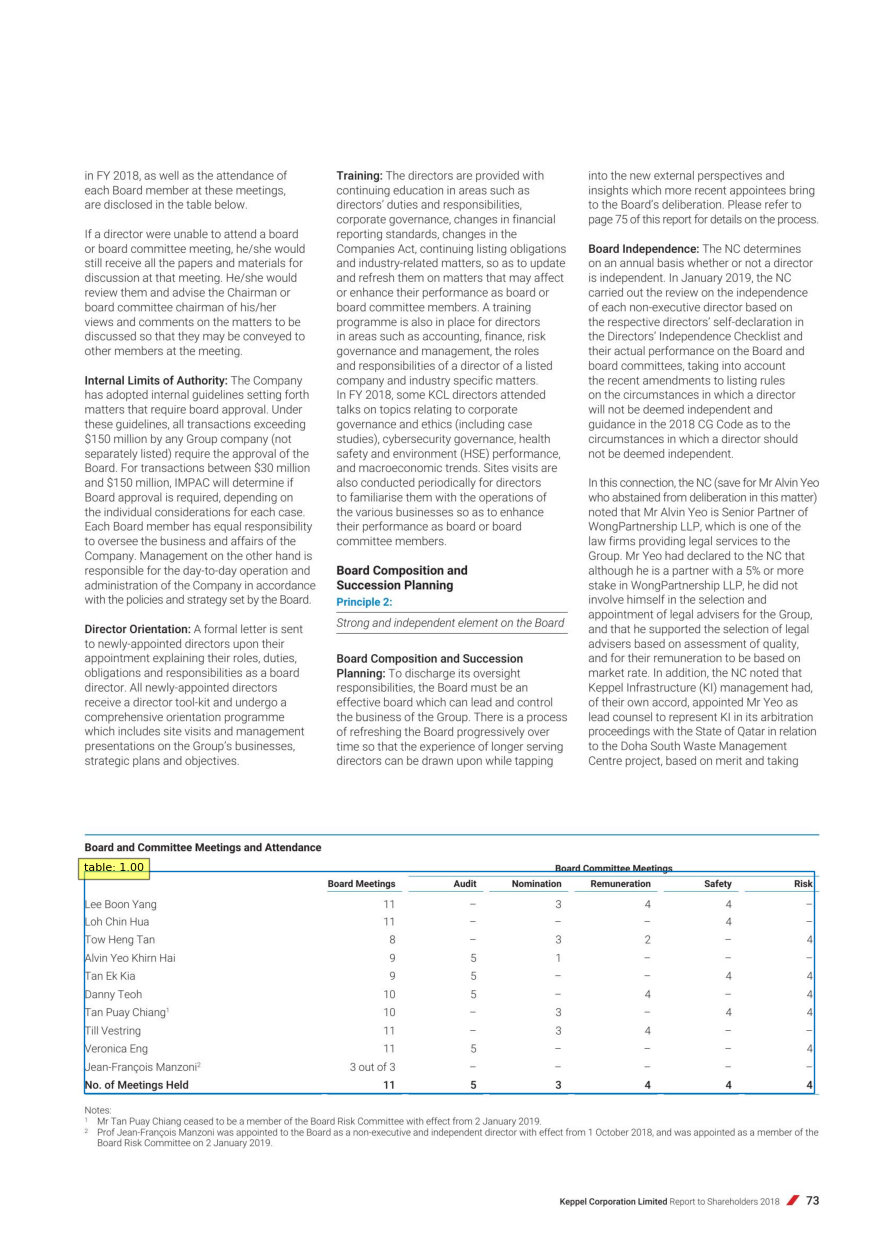

In [31]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [36]:
import cv2
import numpy as np

img = cv2.imread('assets/bbox_table.jpg', cv2.IMREAD_UNCHANGED)

#convert img to grey
img_grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#set a thresh
thresh = 100
#get threshold image
ret,thresh_img = cv2.threshold(img_grey, thresh, 255, cv2.THRESH_BINARY)
#find contours
contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#create an empty image for contours
img_contours = np.zeros(img.shape)
# draw the contours on the empty image
cv2.drawContours(img_contours, contours, -1, (0,255,0), 3)
#save image
cv2.imwrite('assets/bbox_table2.jpg',img_contours)

True

##### Okay, this does not works well. As time is running out, I'll just crop the table only by myself.

# Table Structure recognition

In [41]:
file_path = "assets/contour.jpg"
image = Image.open(file_path).convert("RGB")

In [47]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(24,16))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        # ax.text(xmin, ymin, text, fontsize=0,
        #         bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.savefig('assets/output.jpg', pad_inches=0, bbox_inches="tight")
    plt.show()

In [43]:
encoding = feature_extractor(image, return_tensors="pt")
encoding.keys()

dict_keys(['pixel_values', 'pixel_mask'])

In [44]:
from transformers import TableTransformerForObjectDetection

model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [45]:
with torch.no_grad():
  outputs = model(**encoding)

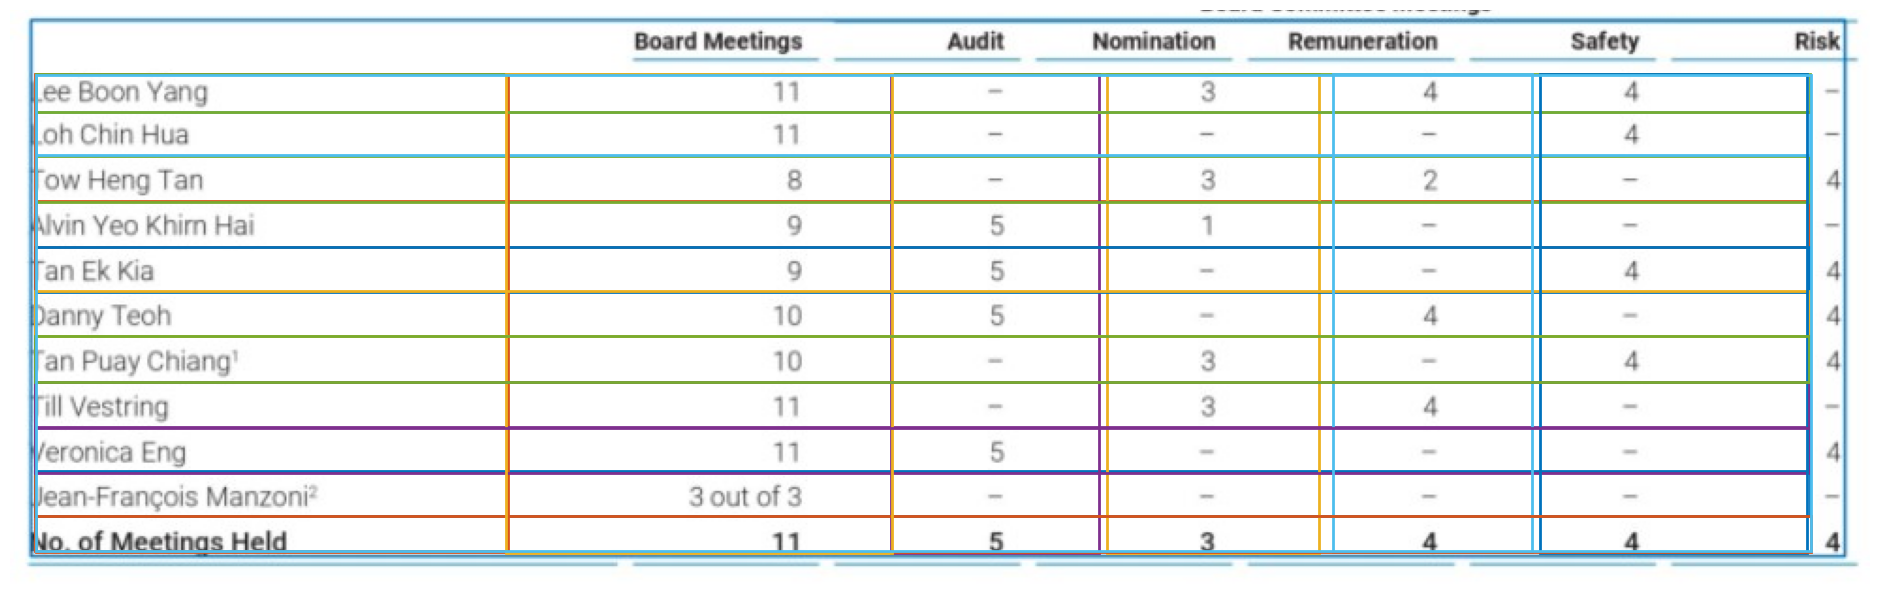

In [48]:
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [49]:
!pip freeze > requirements.txt